In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score,classification_report,f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer 
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 

import math
import torch
from torch import nn
from torch import optim
from torchvision.datasets import MNIST
from torch.utils.data import TensorDataset, DataLoader

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.autograd import Variable
from torchvision import datasets, transforms
import torch.utils.data as utils
from torch.optim import Adam 


In [2]:
trainloader = torch.utils.data.DataLoader(
        datasets.MNIST('MNIST_data/', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('MNIST_data/', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=16, shuffle=True)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
device = torch.device('cpu')

cuda


In [4]:
def call_pr_loss(a , variance):
    k = len(a[0])
    l = torch.sum(a**2)/ variance**2 /2/k
    return k/2*math.log(2*math.pi) + 0.5*k*math.log(variance) + l

In [5]:
m_200 = 1
m_784 = 1

In [6]:
def eva(test_loader , model):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data = data.view(data.size(0), -1)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return (test_loss ,correct / len(test_loader.dataset) )

In [33]:
c = np.logspace(-4 , 4 , 10)

In [35]:
c

array([  1.00000000e-04,   7.74263683e-04,   5.99484250e-03,
         4.64158883e-02,   3.59381366e-01,   2.78255940e+00,
         2.15443469e+01,   1.66810054e+02,   1.29154967e+03,
         1.00000000e+04])

In [42]:
model = nn.Sequential()
model.add_module('l1', nn.Linear(784, 10))
#model.add_module('r1', nn.ReLU())


model.to(device)

Sequential(
  (l1): Linear(in_features=784, out_features=10, bias=True)
)

In [43]:
NUM = 10

In [44]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

model.train()
step = 0 
loss_history = []
for epoch in range(NUM):
    for batch_idx, (data, target) in enumerate(trainloader):
        
        data, target = data.to(device), target.to(device)
        data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        output = model(data)
        loss_0 = criterion(output, target)
        
        loss_1 = call_pr_loss(model.l1.weight , m_784)
        
        
        
        
        
        loss = loss_0   + loss_1
        loss.backward()
        optimizer.step()
        step += 1
        loss_history.append(loss.item())
        if step % 1000  == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} '.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.item()))
    scheduler.step()
    eva( test_loader, model )

Train Epoch: 0 [15984/60000 (27%)]	Loss: 4331.005859 
Train Epoch: 0 [31984/60000 (53%)]	Loss: 4331.293945 
Train Epoch: 0 [47984/60000 (80%)]	Loss: 4331.122559 

Test set: Average loss: 0.0187, Accuracy: 9148/10000 (91%)

Train Epoch: 1 [3984/60000 (7%)]	Loss: 4331.352051 
Train Epoch: 1 [19984/60000 (33%)]	Loss: 4331.208008 
Train Epoch: 1 [35984/60000 (60%)]	Loss: 4331.220215 
Train Epoch: 1 [51984/60000 (87%)]	Loss: 4331.166992 

Test set: Average loss: 0.0169, Accuracy: 9239/10000 (92%)

Train Epoch: 2 [7984/60000 (13%)]	Loss: 4331.005859 
Train Epoch: 2 [23984/60000 (40%)]	Loss: 4331.019043 
Train Epoch: 2 [39984/60000 (67%)]	Loss: 4331.356934 
Train Epoch: 2 [55984/60000 (93%)]	Loss: 4331.260742 

Test set: Average loss: 0.0168, Accuracy: 9248/10000 (92%)

Train Epoch: 3 [11984/60000 (20%)]	Loss: 4331.109863 
Train Epoch: 3 [27984/60000 (47%)]	Loss: 4331.109375 
Train Epoch: 3 [43984/60000 (73%)]	Loss: 4331.021973 
Train Epoch: 3 [59984/60000 (100%)]	Loss: 4331.396484 

Test set

In [46]:
model.l1.weight[1][1]

tensor(0.0293, grad_fn=<SelectBackward>)

In [47]:
b = np.linspace(-10,10,100)

In [48]:
loss_from_t = []
acc = []
s = 0
for i in b:
    model.l1.weight[1][1] = i
    test_loss, accur = eva(test_loader , model)
    loss_from_t.append(test_loss)
    acc.append(accur)
    print(s)
    s += 1
    


Test set: Average loss: 0.0210, Accuracy: 9020/10000 (90%)

0

Test set: Average loss: 0.0208, Accuracy: 9032/10000 (90%)

1

Test set: Average loss: 0.0206, Accuracy: 9042/10000 (90%)

2

Test set: Average loss: 0.0204, Accuracy: 9053/10000 (91%)

3

Test set: Average loss: 0.0202, Accuracy: 9058/10000 (91%)

4

Test set: Average loss: 0.0201, Accuracy: 9068/10000 (91%)

5

Test set: Average loss: 0.0199, Accuracy: 9080/10000 (91%)

6

Test set: Average loss: 0.0197, Accuracy: 9093/10000 (91%)

7

Test set: Average loss: 0.0196, Accuracy: 9102/10000 (91%)

8

Test set: Average loss: 0.0194, Accuracy: 9107/10000 (91%)

9

Test set: Average loss: 0.0193, Accuracy: 9115/10000 (91%)

10

Test set: Average loss: 0.0191, Accuracy: 9119/10000 (91%)

11

Test set: Average loss: 0.0190, Accuracy: 9125/10000 (91%)

12

Test set: Average loss: 0.0189, Accuracy: 9132/10000 (91%)

13

Test set: Average loss: 0.0187, Accuracy: 9134/10000 (91%)

14

Test set: Average loss: 0.0186, Accuracy: 9145/10

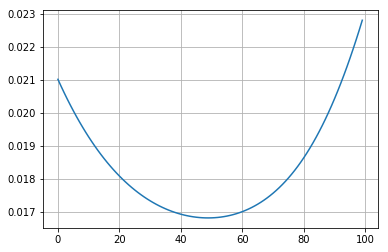

In [51]:
plt.plot(loss_from_t)
plt.grid()

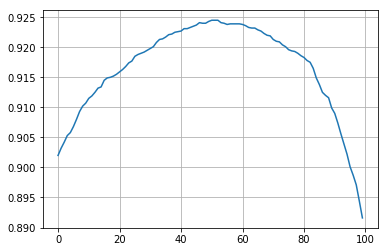

In [52]:
plt.plot(acc)
plt.grid()

In [38]:
b  = np.logspace(-4 , 4 , 20)

In [39]:
test_loss_from_var = []
accur_from_var = []
train_loss_history = []
s = 0
for i in b:
    m_200 = i
    m_784 = i
    model = nn.Sequential()
    model.add_module('l1', nn.Linear(784, 10))

    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

    model.train()
    step = 0 
    loss_history = []
    for epoch in range(1, 3):
        for batch_idx, (data, target) in enumerate(trainloader):

            data, target = data.to(device), target.to(device)
            data = data.view(data.size(0), -1)
            optimizer.zero_grad()
            output = model(data)
            loss_0 = criterion(output, target)
        
            loss_1 = call_pr_loss(model.l1.weight , m_784)

           


            loss = loss_0   + loss_1
            loss.backward()
            optimizer.step()
            step += 1
            loss_history.append(loss.item())
            #if step % 1000  == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} '.format(
            epoch, batch_idx * len(data), len(trainloader.dataset),
            100. * batch_idx / len(trainloader), loss.item()))
        #scheduler.step()  
        
        
    test_loss, accur = eva(test_loader , model)
    
    test_loss_from_var.append(test_loss)
    accur_from_var.append(accur)
    train_loss_history.append(loss_history)
    print(s)
    s += 1
    

Train Epoch: 1 [59984/60000 (100%)]	Loss: -2887.683594 
Train Epoch: 2 [59984/60000 (100%)]	Loss: -2887.544678 

Test set: Average loss: 0.1438, Accuracy: 1135/10000 (11%)

0
Train Epoch: 1 [59984/60000 (100%)]	Loss: -2507.664795 
Train Epoch: 2 [59984/60000 (100%)]	Loss: -2507.616455 

Test set: Average loss: 0.1438, Accuracy: 1135/10000 (11%)

1
Train Epoch: 1 [59984/60000 (100%)]	Loss: -2127.579346 
Train Epoch: 2 [59984/60000 (100%)]	Loss: -2127.604004 

Test set: Average loss: 0.1435, Accuracy: 1135/10000 (11%)

2
Train Epoch: 1 [59984/60000 (100%)]	Loss: -1747.521362 
Train Epoch: 2 [59984/60000 (100%)]	Loss: -1747.507446 

Test set: Average loss: 0.1419, Accuracy: 2059/10000 (21%)

3
Train Epoch: 1 [59984/60000 (100%)]	Loss: -1367.468140 
Train Epoch: 2 [59984/60000 (100%)]	Loss: -1367.582153 

Test set: Average loss: 0.1321, Accuracy: 4163/10000 (42%)

4
Train Epoch: 1 [59984/60000 (100%)]	Loss: -987.848511 
Train Epoch: 2 [59984/60000 (100%)]	Loss: -987.826355 

Test set: Aver

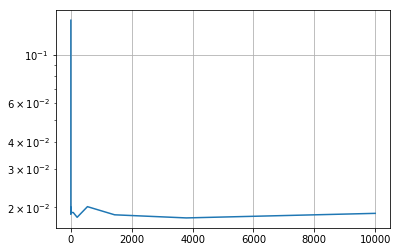

In [40]:
plt.semilogy( b , test_loss_from_var)
plt.grid()

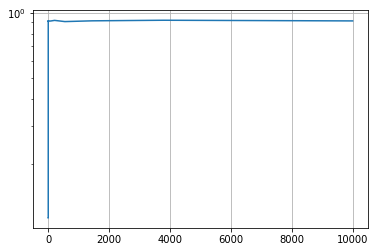

In [41]:
plt.semilogy( b , accur_from_var)
plt.grid()